# Embeddings in protein language models

In [1]:
# Uncomment & execute once to download data
!mkdir -p data
!curl https://alphafold.ebi.ac.uk/files/AF-P35557-F1-model_v6.pdb > data/AF-P35557-F1-model_v6.pdb

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  294k    0  294k    0     0  1786k      0 --:--:-- --:--:-- --:--:-- 1797k


In [2]:
import itertools, numpy as np, pandas as pd, sklearn as sk, sklearn.preprocessing, sklearn.metrics, sklearn.naive_bayes
import matplotlib, matplotlib.colors, matplotlib.pyplot as plt, seaborn as sns
import torch, datasets, evaluate, transformers # Hugging Face libraries https://doi.org/10.18653/v1/2020.emnlp-demos.6
import py3Dmol # Visualising 3D structures; install with pip install py3Dmol

/Users/jianzhouyao/Library/Mobile Documents/com~apple~CloudDocs/Universität/ETH/DL in Biology/Dry_Lab/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import subprocess, sys
subprocess.run([sys.executable, '-m', 'pip', 'install',
    'numpy', 'pandas', 'scikit-learn', 'matplotlib',
    'seaborn', 'torch', 'datasets', 'evaluate',
    'transformers', 'py3Dmol'])


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: pip3 install --upgrade pip


CompletedProcess(args=['/Users/jianzhouyao/Library/Mobile Documents/com~apple~CloudDocs/Universität/ETH/DL in Biology/Dry_Lab/.venv/bin/python', '-m', 'pip', 'install', 'numpy', 'pandas', 'scikit-learn', 'matplotlib', 'seaborn', 'torch', 'datasets', 'evaluate', 'transformers', 'py3Dmol'], returncode=0)

In [4]:
import torch, datasets, evaluate, transformers # Hugging Face libraries https://doi.org/10.18653/v1/2020.emnlp-demos.6

In [5]:
# Load the smallest version of the ESM-2 language model for masked token prediction
model_checkpoint = 'facebook/esm2_t6_8M_UR50D'
unmasker = transformers.pipeline(model=model_checkpoint)
esm_model = unmasker.model.esm
esm_model

Loading weights: 100%|██████████| 112/112 [00:00<00:00, 1847.33it/s, Materializing param=lm_head.layer_norm.weight]                                    
EsmForMaskedLM LOAD REPORT from: facebook/esm2_t6_8M_UR50D
Key                         | Status     |  | 
----------------------------+------------+--+-
esm.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


EsmModel(
  (embeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 320, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): EsmEncoder(
    (layer): ModuleList(
      (0-5): 6 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=320, out_features=320, bias=True)
            (key): Linear(in_features=320, out_features=320, bias=True)
            (value): Linear(in_features=320, out_features=320, bias=True)
            (rotary_embeddings): RotaryEmbedding()
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=320, out_features=320, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (intermediate): EsmIntermediate(
          (dense): Linear(in_features=320, out_features=1280, bias=True)
        )
        (output): EsmOutput(
        

**Q1.** Have a look at the description of the ESM-2 model architecture (Section A.2.3), and Table S3 in the supplementaries of ESM-2 paper ([Lin et al., 2023](https://doi.org/10.1126/science.ade2574)). How many parameters would you expect to see in `esm_model`? Can you adapt the code below to (approximately) count all the parameters?

In [6]:
# Initialize a counter to accumulate the total parameter count
n_esm_parameters = 0

# Iterate over each Transformer block in the ESM-2 encoder
# (esm_model.encoder.layer is a list of TransformerLayer modules)
for layer in esm_model.encoder.layer:
    
    # Access the FFN intermediate (first) linear layer: W1, shape [ffn_dim, hidden_dim]

    # .weight.shape returns a torch.Size object — but note: .shape is redundant here,
    # since .numel() can be called directly on the tensor (.weight.numel())
    n_esm_parameters += layer.intermediate.dense.weight.shape.numel()
    #                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    #                    Only counts W1 of the FFN in each layer —
    #                    misses: biases, attention weights, layer norms, embeddings, LM head

# Print the (incomplete) parameter count

print(n_esm_parameters)

2457600


In [7]:
n_esm_parameters = 0
for p in esm_model.parameters():
    n_esm_parameters += p.numel()
print(n_esm_parameters)  # expect ~8M

7409081


**Q2.** Can you interpret the output of the code below? Can you adapt the code to calculate ESM-2 scores around residue D205 of the GCK glucokinase, and compare the results obtained using ESM-2 to what was observed with AlphaMissense on [Figure 3F](https://www.science.org/doi/10.1126/science.adg7492#sec-5) of [Lin et al., 2023](https://doi.org/10.1126/science.ade2574)?

In [8]:
# Sequence for GCK glucokinase (P35557), see Figure 3F in https://www.science.org/doi/10.1126/science.adg7492#sec-5
seq = 'MLDDRARMEAAKKEKVEQILAEFQLQEEDLKKVMRRMQKEMDRGLRLETHEEASVKMLPTYVRSTPEGSEVGDFLSLDLGGTNFRVMLVKVGEGEEGQWSVKTKHQMYSIPEDAMTGTAEMLFDYISECISDFLDKHQMKHKKLPLGFTFSFPVRHEDIDKGILLNWTKGFKASGAEGNNVVGLLRDAIKRRGDFEMDVVAMVNDTVATMISCYYEDHQCEVGMIVGTGCNACYMEEMQNVELVEGDEGRMCVNTEWGAFGDSGELDEFLLEYDRLVDESSANPGQQLYEKLIGGKYMGELVRLVLLRLVDENLLFHGEASEQLRTRGAFETRFVSQVESDTGDRKQIYNILSTLGLRPSTTDCDIVRRACESVSTRAAHMCSAGLAGVINRMRESRSEDVMRITVGVDGSVYKLHPSFKERFHASVRRLTPSCEITFIESEEGSGRGAALVSAVACKKACMLGQ'
print(seq)

# Mask residue at pos
pos = 2
seq_masked = seq[:pos] + '<mask>' + seq[pos + 1:]
print(seq_masked)

# Apply the ESM-2 model to the masked sequence
unmasker(seq_masked)

MLDDRARMEAAKKEKVEQILAEFQLQEEDLKKVMRRMQKEMDRGLRLETHEEASVKMLPTYVRSTPEGSEVGDFLSLDLGGTNFRVMLVKVGEGEEGQWSVKTKHQMYSIPEDAMTGTAEMLFDYISECISDFLDKHQMKHKKLPLGFTFSFPVRHEDIDKGILLNWTKGFKASGAEGNNVVGLLRDAIKRRGDFEMDVVAMVNDTVATMISCYYEDHQCEVGMIVGTGCNACYMEEMQNVELVEGDEGRMCVNTEWGAFGDSGELDEFLLEYDRLVDESSANPGQQLYEKLIGGKYMGELVRLVLLRLVDENLLFHGEASEQLRTRGAFETRFVSQVESDTGDRKQIYNILSTLGLRPSTTDCDIVRRACESVSTRAAHMCSAGLAGVINRMRESRSEDVMRITVGVDGSVYKLHPSFKERFHASVRRLTPSCEITFIESEEGSGRGAALVSAVACKKACMLGQ
ML<mask>DRARMEAAKKEKVEQILAEFQLQEEDLKKVMRRMQKEMDRGLRLETHEEASVKMLPTYVRSTPEGSEVGDFLSLDLGGTNFRVMLVKVGEGEEGQWSVKTKHQMYSIPEDAMTGTAEMLFDYISECISDFLDKHQMKHKKLPLGFTFSFPVRHEDIDKGILLNWTKGFKASGAEGNNVVGLLRDAIKRRGDFEMDVVAMVNDTVATMISCYYEDHQCEVGMIVGTGCNACYMEEMQNVELVEGDEGRMCVNTEWGAFGDSGELDEFLLEYDRLVDESSANPGQQLYEKLIGGKYMGELVRLVLLRLVDENLLFHGEASEQLRTRGAFETRFVSQVESDTGDRKQIYNILSTLGLRPSTTDCDIVRRACESVSTRAAHMCSAGLAGVINRMRESRSEDVMRITVGVDGSVYKLHPSFKERFHASVRRLTPSCEITFIESEEGSGRGAALVSAVACKKACMLGQ


[{'score': 0.14954549074172974,
  'token': 9,
  'token_str': 'E',
  'sequence': 'M L E D R A R M E A A K K E K V E Q I L A E F Q L Q E E D L K K V M R R M Q K E M D R G L R L E T H E E A S V K M L P T Y V R S T P E G S E V G D F L S L D L G G T N F R V M L V K V G E G E E G Q W S V K T K H Q M Y S I P E D A M T G T A E M L F D Y I S E C I S D F L D K H Q M K H K K L P L G F T F S F P V R H E D I D K G I L L N W T K G F K A S G A E G N N V V G L L R D A I K R R G D F E M D V V A M V N D T V A T M I S C Y Y E D H Q C E V G M I V G T G C N A C Y M E E M Q N V E L V E G D E G R M C V N T E W G A F G D S G E L D E F L L E Y D R L V D E S S A N P G Q Q L Y E K L I G G K Y M G E L V R L V L L R L V D E N L L F H G E A S E Q L R T R G A F E T R F V S Q V E S D T G D R K Q I Y N I L S T L G L R P S T T D C D I V R R A C E S V S T R A A H M C S A G L A G V I N R M R E S R S E D V M R I T V G V D G S V Y K L H P S F K E R F H A S V R R L T P S C E I T F I E S E E G S G R G A A L V S A V A C K K A

The true residue at position 2 is **`D`** (Aspartate), which does **not** appear in the top 5 predictions. However, the top predictions — **E, K, R** — are all **charged residues**, just like D, suggesting ESM-2 has learned meaningful physicochemical constraints at this position even when it fails to recover the exact identity.

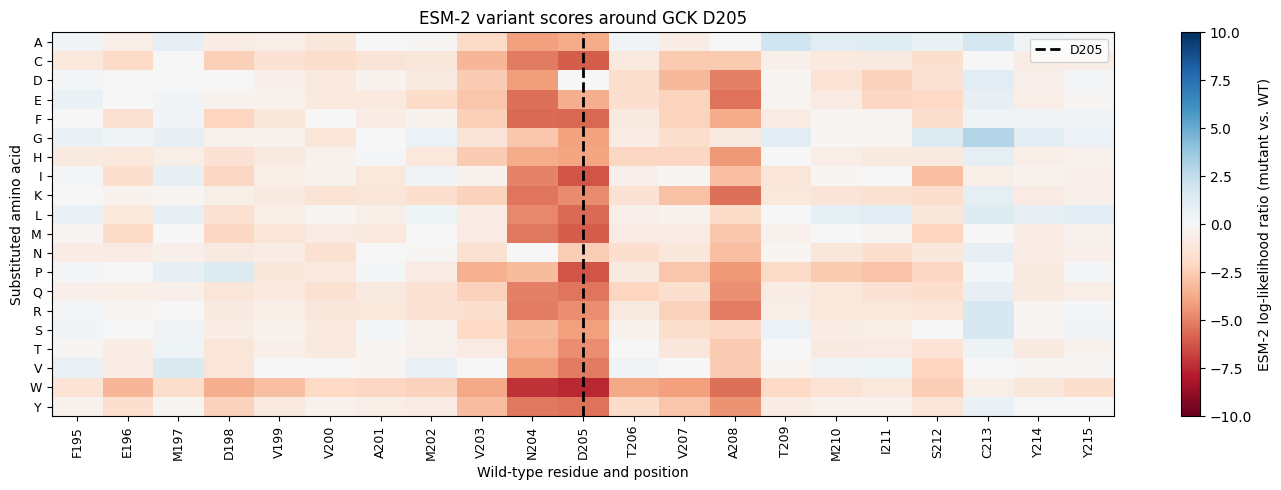

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- Setup ---
center = 204  # D205 is index 204 (0-indexed)
window = 10
positions = range(center - window, center + window + 1)
amino_acids = list('ACDEFGHIKLMNPQRSTVWY')

tokenizer = unmasker.tokenizer
model     = unmasker.model

# ✅ Detect the device the model is on (CPU, CUDA, or MPS) and move inputs there
device = next(model.parameters()).device

aa_token_ids = [tokenizer.convert_tokens_to_ids(aa) for aa in amino_acids]

scores = np.zeros((len(positions), len(amino_acids)))

for i, pos in enumerate(positions):
    seq_masked = seq[:pos] + '<mask>' + seq[pos + 1:]
    
    # ✅ Move input tensors to the same device as the model
    inputs = tokenizer(seq_masked, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}

    mask_idx = (inputs['input_ids'] == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]

    with torch.no_grad():
        logits = model(**inputs).logits

    log_probs = torch.log_softmax(logits[0, mask_idx, :], dim=-1)

    wt_aa       = seq[pos]
    wt_token_id = tokenizer.convert_tokens_to_ids(wt_aa)
    wt_log_prob = log_probs[0, wt_token_id].item()

    for j, aa in enumerate(amino_acids):
        scores[i, j] = log_probs[0, aa_token_ids[j]].item() - wt_log_prob

# --- Plot ---
fig, ax = plt.subplots(figsize=(14, 5))
im = ax.imshow(scores.T, aspect='auto', cmap='RdBu', vmin=-10, vmax=10)
ax.set_xticks(range(len(positions)))
ax.set_xticklabels([f'{seq[p]}{p + 1}' for p in positions], rotation=90, fontsize=9)
ax.set_yticks(range(len(amino_acids)))
ax.set_yticklabels(amino_acids, fontsize=9)
ax.axvline(x=window, color='black', linewidth=2, linestyle='--', label='D205')
ax.legend(loc='upper right', fontsize=9)
plt.colorbar(im, ax=ax, label='ESM-2 log-likelihood ratio (mutant vs. WT)')
ax.set_title('ESM-2 variant scores around GCK D205', fontsize=12)
ax.set_xlabel('Wild-type residue and position')
ax.set_ylabel('Substituted amino acid')
plt.tight_layout()
plt.show()

**Q: Adapt the code to calculate ESM-2 log-likelihood ratio scores in a ±10 residue window around D205 of GCK glucokinase, and compare the results to AlphaMissense predictions from Figure 3F of Brandes et al. (2023).**

Red (negative LLR) → ESM-2 considers that amino acid unlikely at that position based on evolutionary data, meaning the mutation is not tolerated → likely deleterious/pathogenic

Blue (positive LLR) → ESM-2 considers the mutant more likely than the WT → likely tolerated

**Interpretation:**

At **D205** (dashed line), nearly all substitutions show strongly **negative log-likelihood ratios** (deep red), meaning ESM-2 strongly prefers the wild-type aspartate — consistent with AlphaMissense classifying most D205 variants as **pathogenic**. The white cell at D→D confirms the WT score of 0 by definition.

The surrounding window reveals that **N204** and **V203** also show broad intolerance, while positions like **F195**, **M197**, and **C213** are more permissive (lighter or even blue), mirroring the patchy, position-specific tolerance pattern visible in Figure 3F.

The key difference is that AlphaMissense incorporates **structural context and supervised pathogenicity labels**, while ESM-2 relies purely on **evolutionary sequence statistics** — yet both converge on D205 as a highly constrained, disease-relevant hotspot, highlighting the power of sequence-only language models as zero-shot pathogenicity predictors.

**Q3.** Adapt the code below to visualise alpha helices, beta sheets, and binding sites on the GCK glucokinase structure.

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import py3Dmol

# Define residues with Alpha helix / Beta sheet / within a small-molecule binding site (inferred from structure using pymol)
resid_alpha_helix = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 50, 51, 52, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 238, 239, 240, 257, 258, 259, 267, 268, 269, 272, 273, 274, 275, 276, 277, 278, 279, 280, 288, 289, 290, 291, 292, 293, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 322, 323, 324, 325, 332, 333, 334, 335, 336, 337, 338, 339, 340, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 411, 412, 413, 414, 415, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464]
resid_beta_sheet = [72, 73, 74, 75, 76, 77, 78, 79, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 145, 146, 147, 148, 149, 150, 154, 155, 156, 157, 158, 161, 162, 163, 164, 201, 202, 203, 222, 223, 224, 225, 226, 230, 231, 232, 233, 234, 235, 236, 237, 250, 251, 252, 253, 254, 402, 403, 404, 405, 406, 407, 408, 409, 434, 435, 436, 437, 438, 439, 440]
resid_binding_sites = [61, 62, 63, 64, 65, 66, 151, 152, 153, 159, 168, 169, 204, 205, 206, 210, 211, 214, 218, 220, 221, 225, 229, 230, 231, 235, 250, 254, 256, 258, 287, 290, 451, 452, 455, 456, 459]
print(len(resid_alpha_helix), 'residues in alpha helix')
print(len(resid_beta_sheet), 'residues in as beta sheets')
print(len(resid_binding_sites), 'residues in binding sites')

cmap      = matplotlib.colormaps['cividis']   # ✅ matplotlib, not plt
color_pos = matplotlib.colors.to_hex(cmap(255))  # ✅ matplotlib.colors, not plt.colors
color_neg = matplotlib.colors.to_hex(cmap(0))    # ✅ matplotlib.colors, not plt.colors
view = py3Dmol.view()
view.addModel(open('data/AF-P35557-F1-model_v6.pdb', 'r').read(), 'pdb')
view.setStyle({
    'cartoon': {
        'colorscheme': {
            'prop': 'resi',
            'map': { resi + 1: color_pos if resi + 1 in resid_beta_sheet else color_neg for resi in range(len(seq)) },
        },
        'arrows': True,
    }
})
view.zoomTo()
view.show()

230 residues in alpha helix
84 residues in as beta sheets
37 residues in binding sites


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

**Q4.** The code below runs the raw ESM-2 model on the unmasked sequence, capturing hidden state. Find and describe what is returned as hidden state in `outputs`. Complete the function `get_layer_from_output()` and `get_embeddings_from_output()` to extract a specific embedding from a specific layer.

In [11]:
# Detect the device the model lives on (MPS on Apple Silicon, CUDA on Linux/Windows GPU, CPU otherwise)
# This avoids hardcoding 'cuda' and makes the code portable
device = next(unmasker.model.parameters()).device

# Tokenize the full, unmasked GCK sequence and move tensors to the correct device
# return_tensors='pt' → returns PyTorch tensors
# .to(device)         → moves input_ids and attention_mask to MPS/CUDA/CPU
tokens = unmasker.tokenizer(seq, return_tensors='pt').to(device)

# Forward pass through the ESM-2 model
outputs = unmasker.model(
    tokens['input_ids'],          # shape: (1, seq_len+2) , where +2 for [CLS] and [EOS] special tokens
    attention_mask=tokens['attention_mask'],  # 1 for real tokens, 0 for padding
    output_hidden_states=True,    # ← key flag: returns embeddings from ALL 33 layers,
                                  #   not just the final logits
                                  #   outputs.hidden_states is a tuple of 34 tensors:
                                  #   [embedding layer, layer_1, ..., layer_33]
                                  #   each of shape (1, seq_len+2, 320)
)

In [12]:
dir(outputs)

['__annotations__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'attentions',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'hidden_states',
 'items',
 'keys',
 'logits',
 'loss',
 'move_to_end',
 'pop',
 'popitem',
 'setdefault',
 'to_tuple',
 'update',
 'values']

In [13]:
def get_layer_from_output(layer_id):
    """Extract per-residue embeddings from a specific transformer layer.
    Returns np.array of shape (seq_len, 320), with special tokens stripped."""
    hidden_state = outputs.hidden_states[layer_id]  # (1, seq_len+2, 320)
    hidden_state = hidden_state[0, 1:-1, :]         # strip [CLS] and [EOS] → (seq_len, 320)
    return hidden_state.detach().cpu().numpy()       # ✅ detach() removes gradient tracking before numpy conversion

def get_embedding_from_output(layer_id, embedding_id):
    """Extract a single embedding dimension from a given layer.
    Returns np.array of shape (seq_len,) — one scalar value per residue."""
    X = get_layer_from_output(layer_id)
    return X[:, embedding_id]

print(get_embedding_from_output(2, 3).shape)  # expected: (465,)

(465,)


In [14]:
def get_colors(values):
    # Normalize the input values to the [0, 1] range so they can be mapped to colormap positions
    # vmin/vmax are set to the actual min/max of the data → full colormap range is always used
    rescaled = matplotlib.colors.Normalize(vmin=min(values), vmax=max(values))(values)
    
    # Map each normalized value to a hex color using the cividis colormap
    # i + 1 → 1-indexed residue IDs to match PDB convention (PDB residues start at 1)
    # cmap(val) → returns an RGBA tuple for that position in the colormap
    # to_hex()  → converts RGBA to a hex string e.g. '#f5e642'
    pos_col = {i + 1: matplotlib.colors.to_hex(cmap(val)) for i, val in enumerate(rescaled)}
    
    return pos_col  # dict mapping {residue_id: hex_color} e.g. {1: '#00204d', 2: '#f5e642', ...}


view = py3Dmol.view()

# Load the AlphaFold PDB structure for GCK
view.addModel(open('data/AF-P35557-F1-model_v6.pdb', 'r').read(), 'pdb')

view.setStyle({
    'cartoon': {
        'colorscheme': {
            'prop': 'resi',              # colour by residue index
            'map': get_colors(          # pass the {residue_id: hex_color} dict
                get_embedding_from_output(0, 1)  # get a 1D scalar value per residue
                                                 # from layer 0, PCA/UMAP component 1
            ),
        },
        'arrows': True,                 # show arrows on β-strands to indicate direction
    }
})

view.zoomTo()   # auto-zoom to fit the structure in the viewer
view.show()     # render the interactive 3D structure
# --> dimension 1 at layer 0 oscillates rapidly between high and low values at consecutive residues.
# --> does not encode anything structurally meaningful, but is still a valid embedding dimension that the model uses for masked token prediction.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

**Q5.** Have a look at Figures 4 and 5 in [Vig et al., 2021](https://doi.org/10.48550/arXiv.2006.15222) describing how different layers of protein language models seem better at capturing different features on the protein. Try to understand the code below, and adapt it to beta sheets and binding sites. Plot the results in the next cell (complete the code as necessary), and compare the results to what is described in the paper. Finally, use the visualisation code above to plot the best predictor embeddings for alpha helices, beta sheets and binding sites.

does ESM-2, without any supervision, spontaneously learn embedding dimensions that correlate with secondary structure or binding site identity?

Layer 0
  α-helix   — best AUC: 0.598  (dim 151),  dims > 0.7: 0
  β-sheet   — best AUC: 0.591  (dim 153),  dims > 0.7: 0
  bind.site — best AUC: 0.614  (dim 49),  dims > 0.7: 0
Layer 1
  α-helix   — best AUC: 0.690  (dim 220),  dims > 0.7: 0
  β-sheet   — best AUC: 0.693  (dim 197),  dims > 0.7: 0
  bind.site — best AUC: 0.689  (dim 313),  dims > 0.7: 0
Layer 2
  α-helix   — best AUC: 0.720  (dim 17),  dims > 0.7: 1
  β-sheet   — best AUC: 0.700  (dim 174),  dims > 0.7: 0
  bind.site — best AUC: 0.718  (dim 212),  dims > 0.7: 1
Layer 3
  α-helix   — best AUC: 0.680  (dim 46),  dims > 0.7: 0
  β-sheet   — best AUC: 0.748  (dim 192),  dims > 0.7: 1
  bind.site — best AUC: 0.689  (dim 176),  dims > 0.7: 0
Layer 4
  α-helix   — best AUC: 0.750  (dim 203),  dims > 0.7: 2
  β-sheet   — best AUC: 0.847  (dim 192),  dims > 0.7: 14
  bind.site — best AUC: 0.686  (dim 127),  dims > 0.7: 0
Layer 5
  α-helix   — best AUC: 0.705  (dim 6),  dims > 0.7: 2
  β-sheet   — best AUC: 0.779  (dim 43),  di

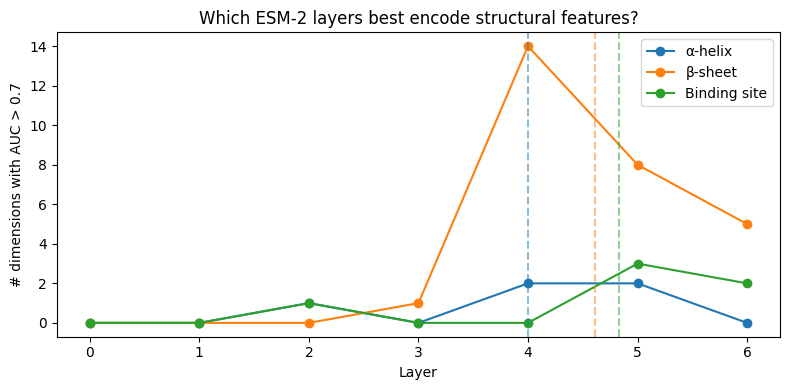

α-helix: layer 4, dim 203, AUC 0.750


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

β-sheet: layer 4, dim 192, AUC 0.847


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Bind. site: layer 5, dim 22, AUC 0.755


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [15]:
from sklearn import metrics as sk_metrics

# --- Ground truth binary labels for each residue (True if in that structural class) ---
y_true_alpha_helix   = [resi + 1 in resid_alpha_helix   for resi in range(len(seq))]
y_true_beta_sheet    = [resi + 1 in resid_beta_sheet    for resi in range(len(seq))]
y_true_binding_sites = [resi + 1 in resid_binding_sites for resi in range(len(seq))]

scores_alpha_helix   = []
scores_beta_sheet    = []
scores_binding_sites = []

# AUC threshold: a dimension is considered "informative" if its AUC > 0.7
# i.e. that single embedding dimension alone can rank residues of that class above others
auc_threshold = 0.7

for layer_id in range(7):  # iterate over first 7 layers (0 = embedding, 1-6 = transformer layers)
    print(f'Layer {layer_id}')
    
    # X: shape (seq_len, 320) — embedding of every residue at this layer
    X = get_layer_from_output(layer_id)

    # For each of the 320 embedding dimensions, compute AUC treating that
    # dimension as a scalar classifier score — how well does this single
    # dimension separate class members from non-members?
    auc_alpha_helix   = np.array([sk_metrics.roc_auc_score(y_true_alpha_helix,   X[:, i]) for i in range(X.shape[1])])
    auc_beta_sheet    = np.array([sk_metrics.roc_auc_score(y_true_beta_sheet,    X[:, i]) for i in range(X.shape[1])])
    auc_binding_sites = np.array([sk_metrics.roc_auc_score(y_true_binding_sites, X[:, i]) for i in range(X.shape[1])])

    # Count how many dimensions exceed the AUC threshold → "score" for this layer
    score_alpha_helix   = sum(auc_alpha_helix   > auc_threshold)
    score_beta_sheet    = sum(auc_beta_sheet    > auc_threshold)
    score_binding_sites = sum(auc_binding_sites > auc_threshold)

    print(f'  α-helix   — best AUC: {max(auc_alpha_helix):.3f}  (dim {np.argmax(auc_alpha_helix)}),  dims > {auc_threshold}: {score_alpha_helix}')
    print(f'  β-sheet   — best AUC: {max(auc_beta_sheet):.3f}  (dim {np.argmax(auc_beta_sheet)}),  dims > {auc_threshold}: {score_beta_sheet}')
    print(f'  bind.site — best AUC: {max(auc_binding_sites):.3f}  (dim {np.argmax(auc_binding_sites)}),  dims > {auc_threshold}: {score_binding_sites}')

    scores_alpha_helix.append(score_alpha_helix)
    scores_beta_sheet.append(score_beta_sheet)
    scores_binding_sites.append(score_binding_sites)

# --- Weighted average layer: where is each feature "best represented"? ---
layers = list(range(7))  # [0, 1, 2, 3, 4, 5, 6]
centre_alpha_helix   = np.average(layers, weights=scores_alpha_helix)
centre_beta_sheet    = np.average(layers, weights=scores_beta_sheet)
centre_binding_sites = np.average(layers, weights=scores_binding_sites)

print(f'\nWeighted centre layers:')
print(f'  α-helix:    {centre_alpha_helix:.2f}')
print(f'  β-sheet:    {centre_beta_sheet:.2f}')
print(f'  bind. site: {centre_binding_sites:.2f}')

# --- Plot: number of informative dimensions per layer for each structural class ---
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(layers, scores_alpha_helix,   marker='o', label='α-helix')
ax.plot(layers, scores_beta_sheet,    marker='o', label='β-sheet')
ax.plot(layers, scores_binding_sites, marker='o', label='Binding site')
ax.axvline(centre_alpha_helix,   linestyle='--', color='C0', alpha=0.5)
ax.axvline(centre_beta_sheet,    linestyle='--', color='C1', alpha=0.5)
ax.axvline(centre_binding_sites, linestyle='--', color='C2', alpha=0.5)
ax.set_xlabel('Layer')
ax.set_ylabel(f'# dimensions with AUC > {auc_threshold}')
ax.set_title('Which ESM-2 layers best encode structural features?')
ax.legend()
plt.tight_layout()
plt.show()

# --- 3D visualisation: colour structure by best-predictor embedding dimension ---
for label, y_true, struct_class in [
    ('α-helix',    y_true_alpha_helix,   'alpha_helix'),
    ('β-sheet',    y_true_beta_sheet,    'beta_sheet'),
    ('Bind. site',  y_true_binding_sites, 'binding_site'),
]:
    # Recompute AUCs at the best layer for this class to find the best dimension
    best_layer = np.argmax([scores_alpha_helix, scores_beta_sheet, scores_binding_sites]
                           [['alpha_helix','beta_sheet','binding_site'].index(struct_class)])
    X = get_layer_from_output(best_layer)
    aucs = np.array([sk_metrics.roc_auc_score(y_true, X[:, i]) for i in range(X.shape[1])])
    best_dim = np.argmax(aucs)

    view = py3Dmol.view()
    view.addModel(open('data/AF-P35557-F1-model_v6.pdb').read(), 'pdb')
    view.setStyle({'cartoon': {
        'colorscheme': {'prop': 'resi', 'map': get_colors(X[:, best_dim])},
        'arrows': True,
    }})
    view.zoomTo()
    print(f'{label}: layer {best_layer}, dim {best_dim}, AUC {aucs[best_dim]:.3f}')
    view.show()

**Layer 0 (input embedding):** All AUCs ~0.6, no dimension exceeds 0.7 — raw amino acid identity alone carries no structural information.

**Layers 1–3 (early layers):** AUCs rise gradually but stay below 0.7 — local context is building but insufficient to distinguish structural classes.

**Layers 4–6 (deep layers):** Clear feature-specific signals emerge:

| Feature | Peak layer | Best AUC | Dims > 0.7 | Weighted centre |
|---|---|---|---|---|
| α-helix | 4 | 0.750 | 2 | **4.00** |
| β-sheet | 4 | **0.847** | **14** | **4.61** |
| Binding site | 5–6 | 0.755 | 3 | **4.83** |

**Key takeaways:**
- The ordering **α-helix < β-sheet < binding site** in weighted centre layers matches Vig et al. (2021) exactly: features requiring more global context emerge in deeper layers
- **β-sheet** is most strongly encoded (14 dims, AUC 0.847) — long-range hydrogen bonding creates a distinctive embedding signature
- **Binding sites** peak latest — functional residues require whole-sequence context only available in deep layers
- **α-helices** are learnable earliest — determined by short-range local sequence patterns

**α-helices — local interactions**
- H-bonds between residues **i and i+4** (only 4 apart)
- ~4 consecutive residues determine helix propensity (alanine favours, proline breaks)
- Predictable from a **short local window** → early layers suffice

**β-sheets — long-range interactions**
- Strands are short (5–10 residues) but H-bond with strands **dozens–hundreds of residues away**
- e.g. in GCK, strand at position ~80 pairs with strand at ~230
- Requires **whole-sequence integration** → signal peaks in deeper layers

**Binding sites — most global feature**
- No simple sequence rule; residues brought into proximity purely by **3D folding**
- Requires understanding the **global fold** → latest weighted centre layer

Each Transformer layer is one round of attention — one "hop" of information across the sequence. Features that require **longer-range context** need more hops to resolve, so they only become decodable in deeper layers.

| Feature | Interaction range | Context needed | Layer |
|---|---|---|---|
| α-helix | i to i+4 | Local | Early |
| β-sheet | Tens–hundreds of residues | Semi-global | Middle |
| Binding site | Determined by 3D fold | Global / Whole sequence | Deep |

> This hierarchy explains why **AlphaFold** was a breakthrough — β-sheet and binding site prediction require exactly the long-range reasoning that deep attention-based architectures excel at.

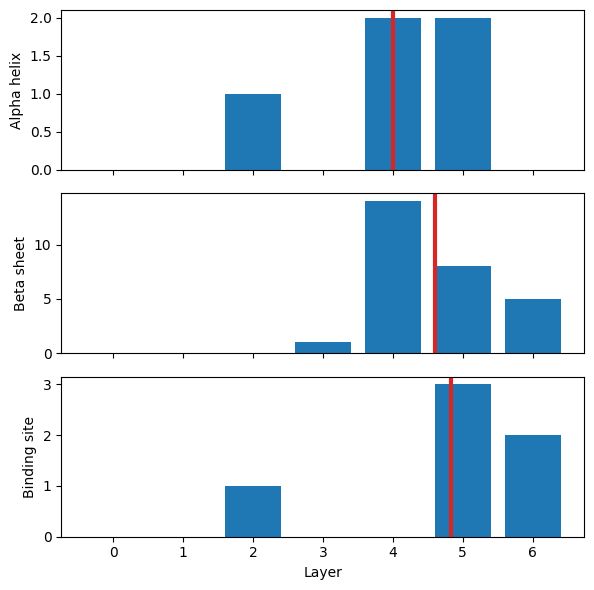

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(6, 6))

plt.subplot(3, 1, 1)
plt.bar(layers, scores_alpha_helix)
plt.axvline(centre_alpha_helix, color='tab:red', linewidth=3)
plt.gca().set_ylabel('Alpha helix')

plt.subplot(3, 1, 2)
plt.bar(layers, scores_beta_sheet)                              # ✅ completed
plt.axvline(centre_beta_sheet, color='tab:red', linewidth=3)   # ✅ completed
plt.gca().set_ylabel('Beta sheet')

plt.subplot(3, 1, 3)
plt.bar(layers, scores_binding_sites)                              # ✅ completed
plt.axvline(centre_binding_sites, color='tab:red', linewidth=3)   # ✅ completed
plt.gca().set_ylabel('Binding site')

plt.gca().set_xlabel('Layer')
plt.tight_layout()
plt.show()

# Transfer Learning: Freeze Early, Fine-tune Late

The red line marks where each feature's signal peaks — and where freezing should stop.

**Frozen layers** — generic sequence representations, already learned from evolution, preserved unchanged.  
**Fine-tuned layers** — task-specific signal not yet fully resolved; supervised labels push these further.

**If one wants to predict alpha helices, freeze layers before 4 and fine tune the later layers + head to achieve a better result.**

Training from scratch would need millions of labelled residues.  
Freezing early layers means you only need labels to adapt the last 1–2 layers — the red line tells you exactly how many.

# ESM-2 Protein Language Model — Notebook Summary

---

## The Central Question

> **Can a language model trained only on protein sequences — with zero structural supervision — spontaneously learn to encode 3D structure and function?**

---

## The Model: ESM-2

| Property | Value |
|---|---|
| Model | `facebook/esm2_t6_8M_UR50D` |
| Architecture | Transformer (BERT-style masked language model) |
| Layers | 6 transformer layers + 1 input embedding = **7 total** |
| Hidden dim | 320 per residue per layer |
| Parameters | ~8 million |
| Training task | **Predict masked amino acids** from surrounding sequence context |
| Training data | Millions of evolutionary protein sequences (no structure labels) |

---

## What Is Being Predicted — At Each Step

### Q2 · Masked Token Prediction *(what ESM-2 was trained to do)*
- **Input:** GCK glucokinase sequence with one residue masked out (`<mask>`)
- **Prediction:** Which amino acid belongs at the masked position?
- **Use here:** Compute a **log-likelihood ratio (LLR)** score for every possible mutation in a ±10 residue window around **D205**
  - `LLR = log P(mutant) − log P(wild-type)`
  - **Red (negative LLR)** → ESM-2 disfavours the mutation → likely **pathogenic**
  - **Blue (positive LLR)** → ESM-2 favours the mutation → likely **tolerated**
- **Comparison:** Results match AlphaMissense (Figure 3F) despite ESM-2 using **no structural or pathogenicity labels**

---

### Q5 · Structural Feature Decoding *(the plot you shared)*
- **Input:** Full unmasked GCK sequence → forward pass → hidden states from all 7 layers, shape `(465 residues × 320 dimensions)` per layer
- **Prediction:** For each of the 320 embedding dimensions at each layer, treat it as a **scalar classifier score** and compute **AUC** against binary ground-truth labels:

| Label | Defined as |
|---|---|
| `y_true_alpha_helix` | Residue index ∈ `resid_alpha_helix` (230 residues, from PyMOL) |
| `y_true_beta_sheet` | Residue index ∈ `resid_beta_sheet` (84 residues, from PyMOL) |
| `y_true_binding_sites` | Residue index ∈ `resid_binding_sites` (37 residues, from PyMOL) |

- **Score per layer** = number of dimensions with **AUC > 0.7** (i.e. a single embedding dimension can rank structural-class residues above non-members)

---

## The Plot — Decoded

```
y-axis: # embedding dimensions (out of 320) with AUC > 0.7
x-axis: Transformer layer (0 = raw amino acid embedding, 1–6 = attention layers)
red line: weighted-average layer where each feature is best encoded
```

| Feature | Peak Layer | Max Dims > 0.7 | Weighted Centre | Why |
|---|---|---|---|---|
| **α-helix** | 4 | 2 | **4.00** | H-bonds span only i→i+4; **local context** suffices |
| **β-sheet** | 4 | ~14 | **4.61** | Strands pair across tens–hundreds of residues; needs **semi-global** context |
| **Binding site** | 5–6 | 3 | **4.83** | Purely determined by 3D fold; requires **whole-sequence** context |

> **The red line shifts right** α-helix → β-sheet → binding site, because each feature requires **one more round of attention** (one more layer) to integrate the necessary sequence context.

---

## Full Pipeline at a Glance

```
Protein sequence (GCK, 465 aa)
        │
        ▼
ESM-2 Tokenizer  →  input_ids  (465 + 2 special tokens)
        │
        ▼
ESM-2 Forward Pass  (output_hidden_states=True)
        │
        ▼
outputs.hidden_states  →  tuple of 7 tensors, each (1, 467, 320)
        │
        ├─► Layer 0  (raw residue embeddings — no context yet)
        ├─► Layers 1–3  (local context building)
        └─► Layers 4–6  (global structural features emerge)
                │
                ▼
        AUC per dimension per layer
                │
                ▼
        Count dims > 0.7  →  bar chart
        Weighted average  →  red line
```

---

## Key Insight

ESM-2 was **never told** what a helix, sheet, or binding site is.  
It learned to predict masked amino acids from evolution — yet its hidden states **spontaneously encode 3D structure**, with structural complexity determining how deep in the network the signal appears.  
This mirrors the finding of **Vig et al. (2021)** and explains why sequence-only LLMs can rival structure-based pathogenicity predictors like AlphaMissense.

# ESM-2 Hidden States and Embeddings

## What is a hidden state?

At every layer, the transformer assigns each residue a vector of 320 numbers — its **hidden state** (also called an **embedding**). This vector is the model's internal representation of that residue, encoding everything it has inferred about it from the surrounding sequence context.

```
Input sequence  →  Tokenizer  →  [CLS] + residues + [EOS]   shape: (1, 467)
                                          |
                              ESM-2 forward pass
                              output_hidden_states=True
                                          |
                              outputs.hidden_states
                              tuple of 7 tensors, each shape: (1, 467, 320)
                                          |
                              strip [CLS] and [EOS]  →  (465, 320)
```

Each tensor in the tuple corresponds to one layer:

| Index | Layer | What it encodes |
|---|---|---|
| `[0]` | Input embedding | Raw amino acid identity only — no context |
| `[1]–[3]` | Early transformer layers | Local sequence patterns |
| `[4]–[6]` | Deep transformer layers | Long-range structure and function |

## What does one embedding dimension represent?

Each of the 320 dimensions is a learned scalar. No single dimension has a hand-labeled meaning — but empirically, some dimensions correlate strongly with biological properties:

- A dimension whose values are high at helix residues and low elsewhere is a **helix-encoding dimension**
- This is measured by treating the dimension as a classifier score and computing its **AUC** against binary structural labels

## Why do deeper layers encode more complex features?

Each transformer layer performs one round of self-attention — one pass where every residue can gather information from every other residue. Features that depend on distant interactions (beta sheets, binding sites) require more passes to resolve.

Fine-tuning ESM2 lets you adapt its pre-learned evolutionary and biophysical representations of protein sequence space to a specific task (e.g., predicting binding or stability) without needing massive compute or data, since training from scratch would fail to capture those rich mechanistic features unless you had billions of sequences and comparable resources.

## ESM2 Fine-tuning: Which Layers to Freeze?

**Rule of thumb:** Early layers = general features (freeze) | Late layers = task-specific (unfreeze)

### Decision factors:
- **Dataset size** → small: freeze more | large: unfreeze more
- **Task similarity to pretraining** → similar: freeze more | different: unfreeze more
- **Compute budget** → more unfrozen layers = more memory/time

### Common strategy:
1. Freeze all ESM2 layers, train head only (few epochs)
2. Unfreeze last 2–4 transformer layers, fine-tune with small lr
3. Optionally unfreeze full model if data is sufficient

### Parameters updated per transformer layer (when unfrozen):
- Attention: Q, K, V, output projection matrices
- FFN: two linear layers + activation
- Layer norms
- **Head** (always trained): linear projection → output classes/values

### Layer count reference:
| Model | Layers | Embed dim |
|-------|--------|-----------|
| ESM2-8M | 6 | 320 |
| ESM2-150M | 30 | 640 |
| ESM2-650M | 33 | 1280 |
| ESM2-3B | 36 | 2560 |

**If don't know where the red verticle line is, set the number of frozen layers as a hyperparameter to compare different models' performance.**